In [1]:
from dotenv import load_dotenv
import os

# Load environment variables from an .env file
load_dotenv()

True

In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
pd.set_option('display.max_rows', 100)  # You can set this to any number
pd.set_option('display.max_columns', 50)  # You can set this to any number

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def load_data_from_db(connection_string, query):
    engine = create_engine(connection_string)
    with engine.connect() as connection:
        df = pd.read_sql(query, connection)
    return df

In [4]:
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_name = os.getenv('DB_NAME')

In [5]:
db_host

'poke-data-dev-db.cjs6u4wm25hq.us-east-1.rds.amazonaws.com'

In [6]:
connection_string = f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}/{db_name}'

In [14]:
df = load_data_from_db(connection_string, """select * from feature_set limit 500000""")

# Select non zero prices

In [15]:
df = df.loc[df.price>0]

# Select cards with non-zero prices and have reached at least 50 USD

In [16]:
df = df.loc[(df.product_type == "card")]

In [17]:
df.shape

(165318, 41)

In [18]:
# Step 1: Group by poke_id and calculate the maximum price for each poke_id
max_prices = df.groupby("poke_id")['price'].max().reset_index()

# Step 2: Filter to find poke_id's where the maximum price is 20 or less
low_price_poke_ids = max_prices[max_prices['price'] <= 50]['poke_id']

# Step 3: Remove rows from the original df where poke_id is in the low_price_poke_ids list
df = df[~df['poke_id'].isin(low_price_poke_ids)]

In [19]:
df.card_type.value_counts()
# TODO: bar plot w/ slider to filter on price (looking at card type distributions at different price points)
# Missing significant number of card types - i.e. should be far less NaNs. Need to scrape 2nd set pages of psa's website as soon as their Public API back up

card_type
NaN                          152133
full art                       1467
full art secret                 814
illustration rare               403
special illustration rare        92
hyper rare                       89
shiny ultra rare                 53
ultra rare                       25
Name: count, dtype: int64

In [22]:
df.shape

(155076, 36)

# Some sets have no Booster box average price for that month due to early release, or only having ETB / other products
- for all sets with missing BB price for early months of release, fill with $100 (unless exceptionally high in later months, then use some backwards fill or smoothing technique)
- For sets with no BB at all, use a ETB conversion formula

In [20]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

In [21]:
mask = (df['release_date'] == df['date']) | (df['release_date'] == (df['date'] - pd.DateOffset(months=1)))

In [22]:
df.loc[mask, 'bb_mo_price_by_set'] = df.loc[mask, 'bb_mo_price_by_set'].fillna(100)

# Get aggregate, monthly prices per grade/set
- in inference, this requires average price of PSA 7-10 card for that month and set, which will likely be unavailable first few months of set release

In [23]:
avg_mo_price_by_grade_set = df.groupby(['date', 'grade', 'set_name']).agg(avg_mo_price_by_grade_set=('price','mean'))

In [24]:
df = pd.merge(df, avg_mo_price_by_grade_set, how="left", on=['date', 'grade', 'set_name'])

<Axes: >

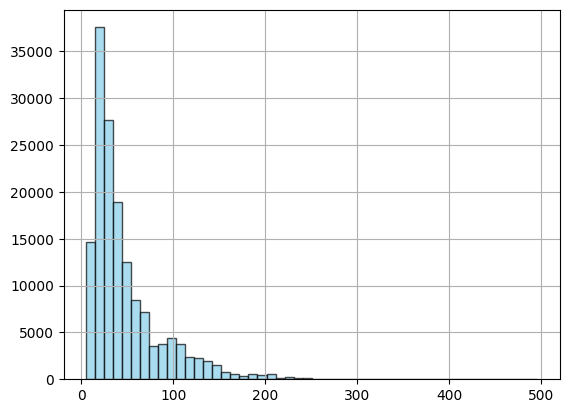

In [25]:
df.avg_mo_price_by_grade_set.loc[df.avg_mo_price_by_grade_set<500].hist(bins=50, color='skyblue', edgecolor='black', alpha=0.7)

# check is_alt_art and is_tag_team

- Is price charting storing pokenumber numbers like SWSH162 Correctly?

In [28]:
unique_alt_arts = len(df.loc[df.is_alt_art==1].drop_duplicates(subset=['poke_name', 'poke_no']))
print(f"{unique_alt_arts} alt art pokemon in dataset")
df.is_alt_art.value_counts()

65 alt art pokemon in dataset


is_alt_art
0    144928
1     10148
Name: count, dtype: int64

In [30]:
unique_tag_teams = len(df.loc[df.is_tag_team==1].drop_duplicates(subset=['poke_name', 'poke_no']))
print(f"{unique_tag_teams} tag team pokemon in dataset")
df.is_tag_team.value_counts()

76 tag team pokemon in dataset


is_tag_team
0    139674
1     15402
Name: count, dtype: int64

In [33]:
unique_zards = len(df.loc[df.is_zard==1].drop_duplicates(subset=['poke_name', 'poke_no']))
print(f"{unique_zards} unique zards in dataset")
df.is_zard.value_counts()

26 unique zards in dataset


is_zard
False    150067
True       5009
Name: count, dtype: int64

# Label exceptionally rare/special promos, or very rare sets
- In progress

# Select features

In [35]:
df.columns

Index(['date', 'price', 'grade', 'poke_name', 'poke_no', 'set_name',
       'product_type', 'set_year', 'set_month', 'execution_datetime',
       'poke_id', 'card_type', 'release_date', 'mos_since_release',
       'num_grade', 'is_secret', 'is_full_art', 'is_full_art_secret', 'is_ir',
       'is_sir', 'ir_score', 'is_ultra_rare', 'is_shiny_rare', 'is_alt_art',
       'is_tag_team', 'is_zard', 'is_eeveelution', 'is_legendary',
       'is_og_char', 'is_gallery', 'avg_mo_price_sealed_in_set',
       'max_mo_price_sealed_in_set', 'avg_mo_price_card_in_set',
       'max_mo_price_card_in_set', 'top10_nm_card_mo_sum_in_set',
       'top10_nm_card_mo_avg_in_set', 'bb_mo_price_by_set',
       'etb_mo_price_by_set', 'top10_mo_card_sum_to_bb_cost_ratio',
       'avg_mo_price_psa_10_in_set', 'max_mo_price_psa_10_in_set',
       'avg_mo_price_by_grade_set'],
      dtype='object')

In [37]:
features = ["mos_since_release", 
            'num_grade',
            'is_secret', 
            'is_full_art', 
            'is_tag_team',
            'is_alt_art',
            'is_eeveelution', 
            'is_legendary',
            'is_zard',
            'is_og_char',
            # add months_since_last_set_release,
            # add broader trend (whats the cost per google trend api for inference.., how hard to get google api into fast api)
            #'bb_mo_price_by_set', 
            #'avg_mo_price_by_grade_set',
            'ir_score'
           ]

df[["poke_id"]+["poke_name"]+features+["price"]].head(3)

,poke_id,poke_name,mos_since_release,num_grade,is_secret,is_full_art,is_tag_team,is_alt_art,is_eeveelution,is_legendary,is_zard,is_og_char,ir_score,price
0,193vivid-voltage,bea,6,8.0,False,False,0,0,False,False,False,False,0,31.0
1,193vivid-voltage,bea,7,8.0,False,False,0,0,False,False,False,False,0,31.0
2,193vivid-voltage,bea,8,8.0,False,False,0,0,False,False,False,False,0,31.0


# Corr matrix

In [38]:
df.shape

(155076, 42)

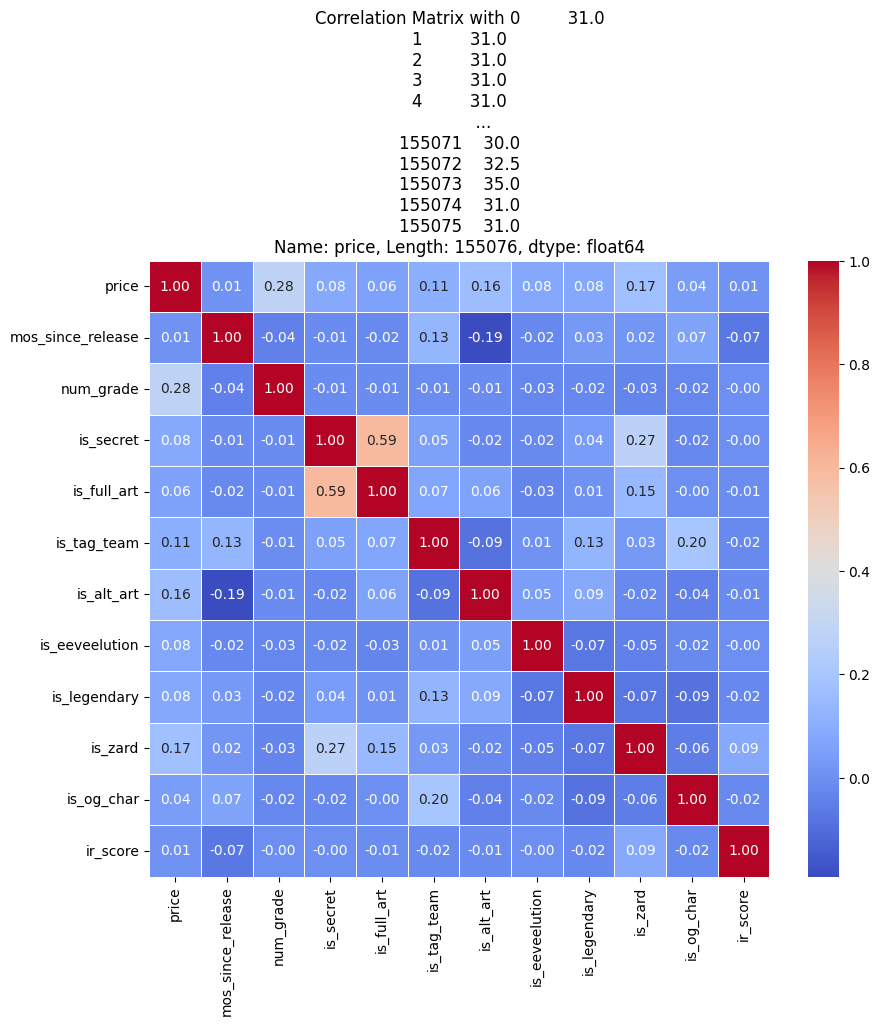

In [39]:
def plot_correlation_matrix(df, target_col):
    corr = df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(f'Correlation Matrix with {target_col}')
    plt.show()
    
plot_correlation_matrix(df[["price"]+features], df["price"])

# Train model

In [77]:
def train_xgboost_model(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', learning_rate=0.3, 
                         max_depth=3, 
                         n_estimators=50)

    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)  # RMSE (Root Mean Squared Error)
    print(f'XGBoost model RMSE: {rmse:.4f}')
    return model

In [78]:
xgb_model = train_xgboost_model(df[features], df["price"])

XGBoost model RMSE: 72.9032


C:\Users\huang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


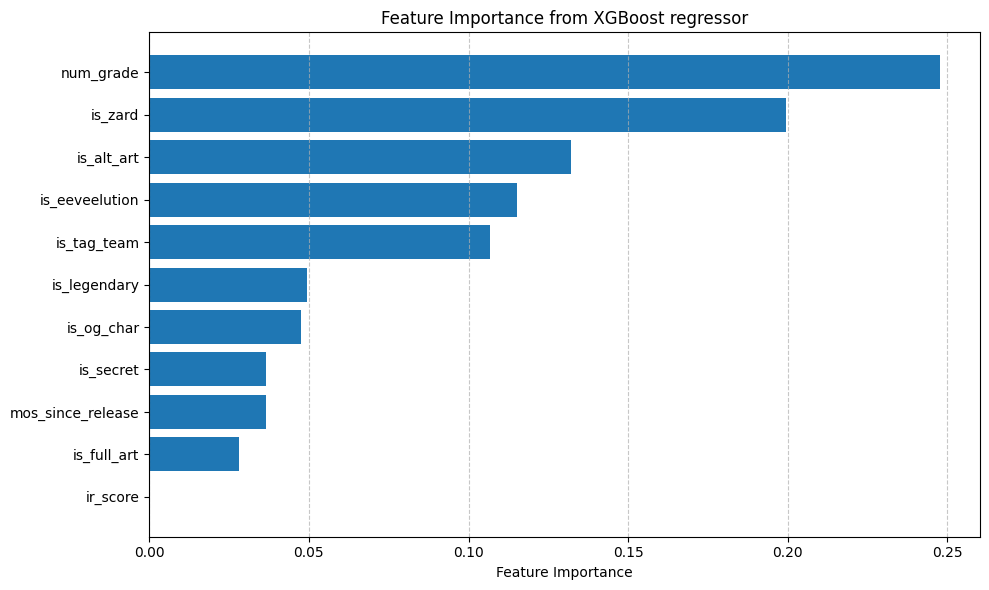

In [42]:
def plot_feature_importance(model, X):
    feature_importances = model.feature_importances_

    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
    plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
    plt.xlabel("Feature Importance")
    plt.title("Feature Importance from XGBoost regressor")
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

plot_feature_importance(xgb_model, df[features])

# Look at price distribution, clipped

In [43]:
clipped = df.loc[df.price<=1000]
print(clipped.price.mean())
print(df.price.mean())

46.60267829017016
48.14860829528747


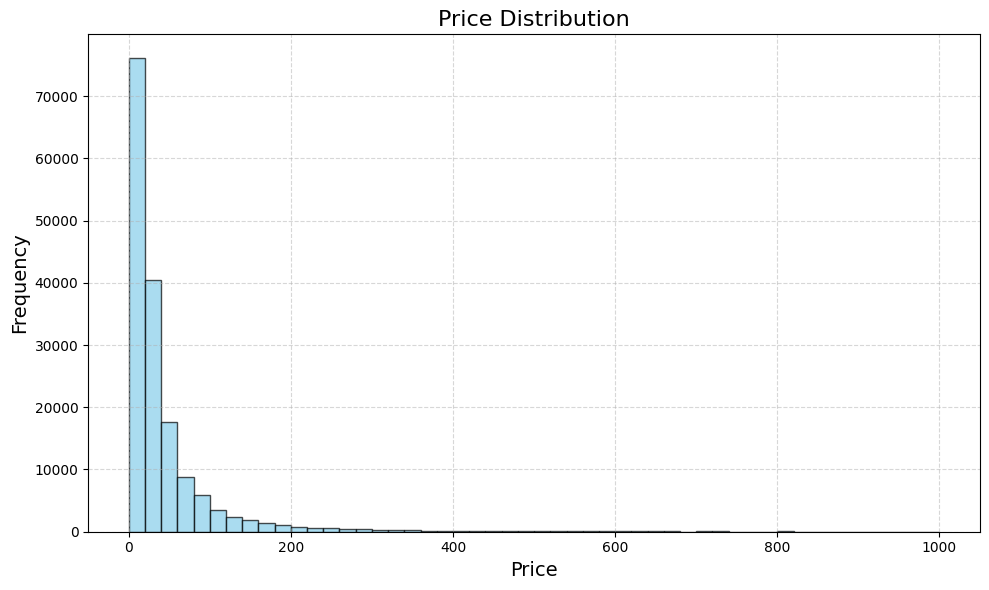

In [136]:
plt.figure(figsize=(10, 6))
plt.hist(clipped["price"], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Price Distribution', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

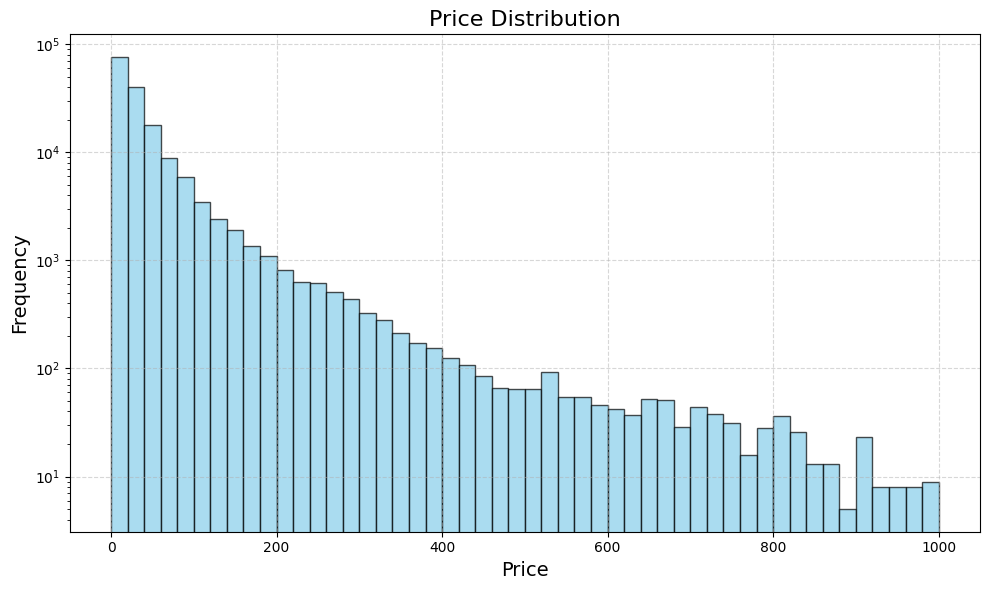

In [137]:
plt.figure(figsize=(10, 6))
plt.hist(clipped["price"], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Price Distribution', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale("log")
plt.tight_layout()

# GridSearch + CV

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [8,15],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse'),
                           param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(df[features], df["price"])
print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100}


In [40]:
# Best parameters and corresponding RMSE (calc from negative MSE)
print("Best parameters:", grid_search.best_params_)
best_score = np.sqrt(-grid_search.best_score_)  # Convert from negative MSE to RMSE
print("Best RMSE score:", best_score)

results = grid_search.cv_results_

results_df = pd.DataFrame(results)
results_df = results_df[['mean_test_score', 'std_test_score', 'param_learning_rate', 'param_max_depth', 'param_n_estimators']]
results_df['mean_test_rmse'] = np.sqrt(-results_df['mean_test_score'])  # Convert MSE to RMSE
results_df['std_test_rmse'] = np.sqrt(results_df['std_test_score'])  # Convert std MSE to RMSE
results_df.sort_values(by="mean_test_rmse", ascending=True).head(5)

Best parameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100}
Best RMSE score: 71.48919044730565


,mean_test_score,std_test_score,param_learning_rate,param_max_depth,param_n_estimators,mean_test_rmse,std_test_rmse
0,-5110.704351,1948.255154,0.01,8,100,71.489190,44.139043
1,-5406.424719,2073.402802,0.01,8,200,73.528394,45.534633
2,-5466.859008,2109.085284,0.01,15,100,73.938211,45.924779
3,-6107.548788,2276.802971,0.01,15,200,78.150808,47.715857
4,-6134.253238,2494.383480,0.10,8,100,78.321474,49.943803


# Check under/overfit with best model

In [95]:
def train_xgboost_model(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)  # RMSE (Root Mean Squared Error)
    print(f'XGBoost model RMSE: {rmse:.4f}')
    return model

learning_rate=0.01, max_depth=5 to 7, n_estimators=150

In [79]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df["price"], test_size=0.2, random_state=42)


# Initialize XGBoost model with specified hyperparameters
model = xgb.XGBRegressor(objective='reg:squarederror', 
                         eval_metric='rmse',
                         learning_rate=.3, 
                         max_depth=3, 
                         n_estimators=50)

# Fit the model to the training data
model.fit(df[features], df["price"])

# Make predictions on both training and validation sets
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Calculate RMSE for training and validation sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"diff: {round(abs(train_rmse-val_rmse),2)}")

mean_price = df.price.mean()
std_dev = np.sqrt(df['price'].var())
print("\nMean Price is", mean_price, "with std_dev", std_dev)

Training RMSE: 76.4019
Validation RMSE: 72.7836
diff: 3.62

Mean Price is 48.14860829528747 with std_dev 89.31671957534277


# Test prediction

In [83]:
import numpy as np

def predict_card_price(model, test_features, feature_columns):
    test_features = pd.DataFrame([test_features], columns=feature_columns)
    
    predicted_price = model.predict(test_features)[0]
    
    return predicted_price

# Test on whole df

In [80]:
X = df.drop(columns=['price'])

In [81]:
X = X[features]

In [82]:
#dtest = xgb.DMatrix(X)

# Perform predictions
predictions = xgb_model.predict(X)

# If you want to add the predictions as a new column in the original DataFrame
df['predictions'] = predictions

# Display the DataFrame with predictions
print(df[['price', 'predictions']].head())

rmse = np.sqrt(((df['predictions'] - df['price']) ** 2).mean())

print("\nRMSE:", rmse)

   price  predictions
0   31.0    11.686567
1   31.0    11.686567
2   31.0    11.686567
3   31.0    11.472759
4   31.0    11.424140

RMSE: 75.73485381124776


In [84]:
# move predictions to front
cols = ['predictions'] + [col for col in df.columns if col != 'predictions']
df = df[cols]

# Look at more expensive cards, how was RSME on these?
- Model struggles with outlier big hits

In [85]:
over_50 = df.loc[df.price>=50]

In [86]:
rmse = np.sqrt(((over_50['predictions'] - over_50['price']) ** 2).mean())

print("RMSE:", rmse)

RMSE: 145.78424900060566


In [87]:
over_50.groupby("poke_id").agg("first").sort_values(by="price", ascending=False).head(10)

,predictions,date,price,grade,poke_name,poke_no,set_name,product_type,set_year,set_month,execution_datetime,card_type,release_date,mos_since_release,num_grade,is_secret,is_full_art,is_full_art_secret,is_ir,is_sir,ir_score,is_ultra_rare,is_shiny_rare,is_alt_art,is_tag_team,is_zard,is_eeveelution,is_legendary,is_og_char,is_gallery,avg_mo_price_sealed_in_set,max_mo_price_sealed_in_set,avg_mo_price_card_in_set,max_mo_price_card_in_set,top10_nm_card_mo_sum_in_set,top10_nm_card_mo_avg_in_set,bb_mo_price_by_set,etb_mo_price_by_set,top10_mo_card_sum_to_bb_cost_ratio,avg_mo_price_psa_10_in_set,max_mo_price_psa_10_in_set,avg_mo_price_by_grade_set
poke_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sv107shining-fates,168.160461,2021-03-01,1089.00,bgs_9_half,charizard-vmax,sv107,shining-fates,card,2019,2,2024-11-07 02:29:34.089975,NaN,2019-02-01,25,9.5,False,False,False,False,False,0,False,False,0,0,True,False,False,False,False,27.87,52.50,20.26,376.46,621.56,62.156,NaN,52.50,NaN,39.96,1416.00,1089.000000
sv49hidden-fates,166.940109,2021-02-01,920.00,bgs_9_half,charizard-gx,sv49,hidden-fates,card,2019,9,2024-11-07 02:23:10.143346,NaN,2019-09-01,17,9.5,False,False,False,False,False,0,False,False,0,0,True,False,False,False,False,0.00,0.00,39.48,180.00,916.49,91.649,NaN,0.00,NaN,202.19,1475.50,257.833333
45evolutions,105.279251,2024-07-01,900.00,psa_10,nidoking,45,evolutions,card,2016,11,2024-11-07 01:10:58.034769,NaN,2016-11-01,92,10.0,False,False,False,False,False,0,False,False,0,0,False,False,False,False,False,225.50,680.00,6.14,37.50,160.30,16.030,680.00,NaN,0.235735,140.03,1475.00,146.175349
151ultra-prism,36.367741,2021-02-01,837.50,bgs_9_half,lillie,151,ultra-prism,card,2018,2,2024-11-07 01:17:44.798059,NaN,2018-02-01,36,9.5,False,False,False,False,False,0,False,False,0,0,False,False,False,False,False,0.00,0.00,19.27,225.45,588.47,58.847,0.00,NaN,inf,67.70,1500.00,837.500000
170team-up,129.039276,2022-03-01,700.00,bgs_9_half,latias-&-latios-gx,170,team-up,card,2019,2,2024-11-07 02:17:28.354983,NaN,2019-02-01,37,9.5,False,False,False,False,False,0,False,False,0,1,False,False,True,False,False,327.48,629.98,28.02,266.82,730.59,73.059,629.98,0.00,1.159703,149.94,742.56,428.750000
188vivid-voltage,65.126900,2021-02-01,677.32,bgs_9_half,pikachu-vmax,188,vivid-voltage,card,2020,11,2024-11-07 00:47:24.752034,NaN,2020-11-01,3,9.5,False,False,False,False,False,0,False,False,0,0,False,False,False,True,False,91.90,177.13,18.31,81.91,421.04,42.104,177.13,0.00,3.275560,100.67,1300.00,243.323333
224chilling-reign,65.126900,2021-09-01,639.00,bgs_9_half,snorlax,224,chilling-reign,card,2021,6,2024-11-07 02:11:59.625423,NaN,2021-06-01,3,9.5,False,False,False,False,False,0,False,False,0,0,False,False,False,True,False,127.50,127.50,28.58,117.47,687.80,68.780,127.50,NaN,5.394510,157.52,810.00,639.000000
181team-up,61.982475,2021-03-01,550.00,psa_10,sabrina's-suggestion,181,team-up,card,2019,2,2024-11-07 02:18:03.138319,NaN,2019-02-01,25,10.0,False,False,False,False,False,0,False,False,0,0,False,False,False,False,False,487.75,1821.34,26.10,90.00,635.32,63.532,1821.34,457.43,1.128757,92.40,550.00,222.835882
218evolving-skies,149.651718,2021-10-01,525.00,bgs_9_half,rayquaza-vmax,218,evolving-skies,card,2021,8,2024-11-07 01:36:21.421438,NaN,2021-08-01,2,9.5,False,False,False,False,False,0,False,False,1,0,False,False,True,False,False,0.00,0.00,44.37,228.00,1058.04,105.804,0.00,NaN,inf,227.08,645.00,368.501429


# Save TF Model

from datetime import datetime


current_datetime = datetime.now()
formatted_date = current_datetime.strftime('%m-%d-%Y')
model.save_model(f'my_model_{formatted_date}.bin')

- df['rarity_score'] = df[['is_secret', 'is_full_art', 'is_legendary']].sum(axis=1)
- df['popularity_score'] = df[['is_eeveelution', 'is_og_char', 'is_gallery']].sum(axis=1)
- df['ir_score'] = df.apply(lambda row: 3 if row['is_sir'] else (1 if row['is_ir'] else 0), axis=1)

# Formatted test payload

In [145]:
test_features = {
    "mos_since_release": 5,
    'num_grade': 10,
    'is_secret': 0, 
    'is_alt_art': 1,
    "is_zard": 0,
    'is_tag_team': 0,
    'is_full_art': 0, 
    'is_eeveelution': 0, 
    'is_legendary': 1,
    'is_og_char': 0,
    'ir_score': 0
}

predicted_price = predict_card_price(model, test_features, features)

print(f"Predicted price for the card: ${predicted_price:.2f}")

Predicted price for the card: $202.79


# How to prevent non-zero / non-negative / unrealistic price predictions? 
- give model more examples...
- handle with railguards post inference (step functions or rules to process model predictions and handle well)